# Modelo predictivo Churn: XGBoost

## Importación módulos y dataset

In [ ]:
#Instalación de adjusText para que no se superpongan los textos de los modelos en el scatterplot.
!pip install adjustText

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7097 sha256=a461e1fd6805202617891cce8f0a3848c942afc00dd68ae3161670a722a27da6
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText


In [ ]:
#Importación librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, average_precision_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
from adjustText import adjust_text
import time
from google.colab import drive

In [ ]:
#Montamos Google Drive y lo convertimos en el directorio de trabajo
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/Colab Notebooks/practice


In [ ]:
#Importación dataset desde github 
#Obtenido de Kaggle https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset
url='https://raw.githubusercontent.com/neoncoip/practice/main/Telco_customer_churn.csv'
telco = pd.read_csv(url, sep=';')
pd.options.display.max_columns = None
display(telco.head())

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783","33,964131","-118,272783",Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,"53,85","108,15",Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742","34,059281","-118,307420",Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,"70,7","151,65",Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953","34,048013","-118,293953",Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,"99,65","820,5",Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709","34,062125","-118,315709",Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,"104,8","3046,05",Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293","34,039224","-118,266293",Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),"103,7","5036,3",Yes,1,89,5340,Competitor had better devices


## Modelo 1: XGBoost Classifier default

#### Preparamos datos para entrenar el modelo

Para todos los modelos eliminamos:
>*   **'CustomerID'**: no encontramos patrones en los números ni letras. 
>*   **'Count'**: todos los registros son iguales.
>*   **'Lat Long'**: contiene los mismos valores que 'Latitude' y 'Longitude' pero concatenados.
>*   **'Country'** y **'State'**: los datos corresponden únicamente al estado de California, Estados Unidos.
>*   **'Churn Label'** y **'Churn Value'**: 'Churn Value' pertenece a las etiquetas "y", Churn Label es redundante.
>*   **'Churn Score'**: Esto es parte de una predicción anterior y lo usaremos sólo para encontrar una referencia de resultados.
>*   **'Churn Reason'**: Texto vinculado a los casos con churn positivo.
>*   **'CLTV'**: Esta variable también es una predicción previa.
>*   **'Total Charges'**: Como vimos presenta una correlación fuerte con Tenure Months.


In [ ]:
#Definimos semilla
seed=1972

#Asignamos serie de etiquetas
y = telco['Churn Value'].copy()

#Asignamos a un nuevo dataframe el dataset original sin las columnas comentadas
X_pre = telco.drop(['CustomerID', 'Count', 'Country', 'State', 'Lat Long', 'Churn Label', 'Churn Value', 'Churn Score', 'Churn Reason', 'CLTV', 'Total Charges'], axis=1)
print(X_pre.shape)
X_pre.columns

(7043, 22)


Index(['City', 'Zip Code', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges'],
      dtype='object')

In [ ]:
#Definimos una lista con las columnas a convetir a número (Esto lo hallamos en el Análisis )
cols = ['Longitude', 'Latitude', 'Monthly Charges']

#Reemplazamos la coma por punto y el espacio por nada y convertimos a número
X_pre[cols] = X_pre[cols].apply(lambda x: x.str.replace(',', '.')).apply(lambda x: x.str.replace(' ', '0')).apply(lambda x: pd.to_numeric(x))
print(X_pre[cols].info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Longitude        7043 non-null   float64
 1   Latitude         7043 non-null   float64
 2   Monthly Charges  7043 non-null   float64
dtypes: float64(3)
memory usage: 165.2 KB
None


In [ ]:
#Convertimos variables categóricas a nuevas variables binarias.
X = pd.get_dummies(X_pre)
print(X.shape, y.shape, X.columns)

#Dividimos los datos en set de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, stratify=y)

(7043, 1177) (7043,) Index(['Zip Code', 'Latitude', 'Longitude', 'Tenure Months', 'Monthly Charges',
       'City_Acampo', 'City_Acton', 'City_Adelanto', 'City_Adin',
       'City_Agoura Hills',
       ...
       'Streaming Movies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'Paperless Billing_No', 'Paperless Billing_Yes',
       'Payment Method_Bank transfer (automatic)',
       'Payment Method_Credit card (automatic)',
       'Payment Method_Electronic check', 'Payment Method_Mailed check'],
      dtype='object', length=1177)


In [ ]:
#Definimos función para calcular las métricas relevantes para cada modelo que construyamos
def met_gra(y_test, y_pred_test, y_train, y_pred_train, want_return=True): 
  
  #Seteamos decimales para el redondeo
  deci = 2
  
  #Calculamos F1 para train y test para monitorear el overfiting
  train_f1 = f1_score(y_train, y_pred_train)
  test_f1 = f1_score(y_test, y_pred_test)
  
  #Calculamos las métricas relevantes del problema e imprimimos resultados
  rec_score = recall_score(y_test, y_pred_test)
  pre_score = precision_score(y_test, y_pred_test)
  print('test/train F1= '+round(test_f1/train_f1, deci).astype(str),
        'recall = '+round(rec_score, deci).astype(str),
        'precision = '+round(pre_score, deci).astype(str), sep='\n')
  
  #Graficamos matriz de confusión y matrix PR
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='all', labels=[1, 0], colorbar=False, cmap='BuPu', ax=ax[0])
  PrecisionRecallDisplay.from_predictions(y_test, y_pred_test, ax=ax[1])
  plt.legend(loc='best')
  plt.show()
  
  #Devolvemos los valores en caso que se especifique lo contrario en el llamado
  if want_return:
    return round(rec_score, 2), round(pre_score, 2), round(test_f1, 3)

test/train F1= 0.96
recall = 0.58
precision = 0.68


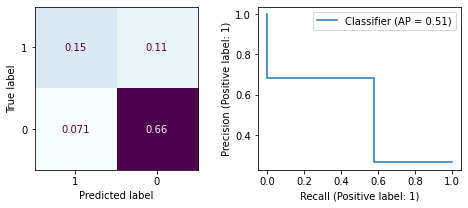

Tiempo de ejecución: 21 segundos


In [ ]:
#Para monitorear el tiempo de ejecución definimos tiempo de comienzo
start = time.time()

#Instanciamos clasificados XGBoost
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', seed=seed)

#Entrenamos el modelo
xgb_clf.fit(X_train, y_train)

#Calculamos predicciones del modelo sobre el test de entrenamiento y de pruebas
y_pred_test = xgb_clf.predict(X_test)
y_pred_train = xgb_clf.predict(X_train)
end = time.time()

#Monitoreamos tiempo transcurrido
elapsed_1 = end - start

#Calculamos y mostramos métricas, guardamos f1 score para comparar performance con el siguiente modelo
_, _, f1_1 = met_gra(y_test, y_pred_test, y_train, y_pred_train)

#Mostramos el tiempo de ejecución
print(f'Tiempo de ejecución: {round(elapsed_1)} segundos')

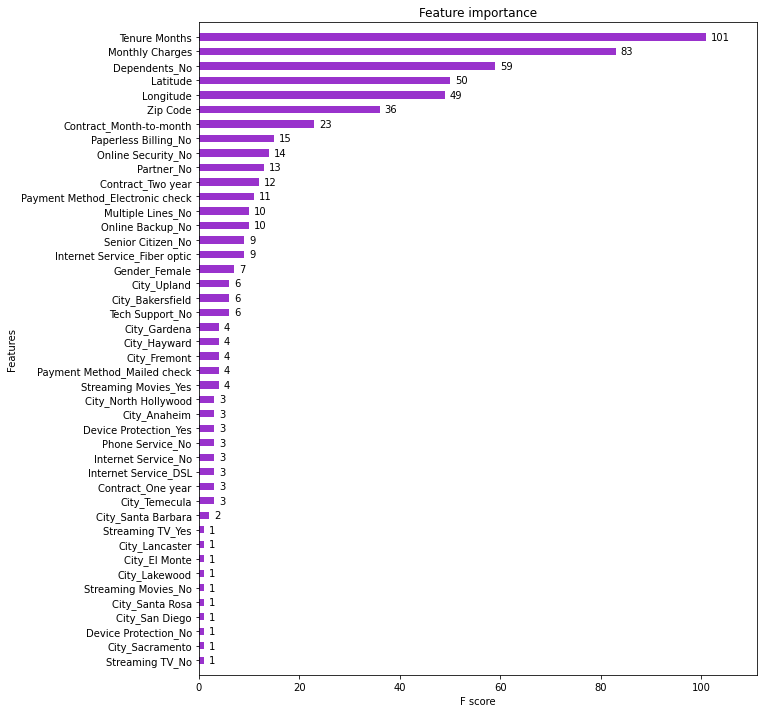

In [ ]:
#Plotemos la lista de atributos y su importancia relativa
fig, ax = plt.subplots(figsize=(10,12))
xgb.plot_importance(xgb_clf, ax=ax, height=0.5, color='darkorchid')
plt.grid(False)
plt.show()

## Modelo 2: XGBoost Classifier default + dataset optimizado 

Saquemos algunos datos adicionales haciéndolo más económico para el cálculo computacional. Principalmente "City" genera 1128 columnas adicionales al dataset que podemos ahorrar y recolectar desde "Latitude" y "Longitude". "ZIP Code" aunque no es categórico es ordinal y puede dar una incorrecta idea de orden como input, también lo eliminamos.

In [ ]:
#Almacenamos una copia de nuestras etiquetas
y = telco['Churn Value'].copy()

#Eliminamos las columnas en cuestión
X_pre = X_pre.drop(['City', 'Zip Code'], axis=1)

#Controlamos resultados
print(X_pre.shape)
X_pre.columns

(7043, 20)


Index(['Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner',
       'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines',
       'Internet Service', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges'],
      dtype='object')

In [ ]:
#Convertimos variables categóricas a nuevas variables binarias y controlamos resultado
X = pd.get_dummies(X_pre)
print(X.shape, y.shape, X.columns)

(7043, 47) (7043,) Index(['Latitude', 'Longitude', 'Tenure Months', 'Monthly Charges',
       'Gender_Female', 'Gender_Male', 'Senior Citizen_No',
       'Senior Citizen_Yes', 'Partner_No', 'Partner_Yes', 'Dependents_No',
       'Dependents_Yes', 'Phone Service_No', 'Phone Service_Yes',
       'Multiple Lines_No', 'Multiple Lines_No phone service',
       'Multiple Lines_Yes', 'Internet Service_DSL',
       'Internet Service_Fiber optic', 'Internet Service_No',
       'Online Security_No', 'Online Security_No internet service',
       'Online Security_Yes', 'Online Backup_No',
       'Online Backup_No internet service', 'Online Backup_Yes',
       'Device Protection_No', 'Device Protection_No internet service',
       'Device Protection_Yes', 'Tech Support_No',
       'Tech Support_No internet service', 'Tech Support_Yes',
       'Streaming TV_No', 'Streaming TV_No internet service',
       'Streaming TV_Yes', 'Streaming Movies_No',
       'Streaming Movies_No internet service', 'Strea

test/train F1= 0.96
recall = 0.58
precision = 0.69


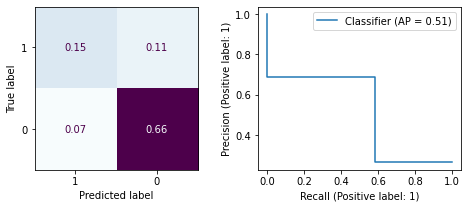

Tiempo de ejecución: 2 segundos
El tiempo de ejecución se redujo un 91%
La performance (F1) aumentó un 1%


In [ ]:
#Dividimos los datos en set de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, stratify=y)

#Para monitorear el tiempo de ejecución definimos tiempo de comienzo
start = time.time()

#Instanciamos clasificador, lo entrenamos y calculamos predicciones sobre el set de entrenamiento y prueba
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', seed=seed)
xgb_clf.fit(X_train, y_train)
y_pred_test = xgb_clf.predict(X_test)
y_pred_train = xgb_clf.predict(X_train)

#Calculamos tiempo de ejecución
end = time.time()
elapsed_2 = end - start

#Calculamos y mostramos las métricas relevantes con nuestra función personalizada
rec_xgb_std , prec_xgb_std, f1_2 = met_gra(y_test, y_pred_test, y_train, y_pred_train)

#Mostramos resultados
print(f'Tiempo de ejecución: {round(elapsed_2)} segundos')
print(f'El tiempo de ejecución se redujo un {round((1-(elapsed_2/elapsed_1))*100)}%')
print(f'La performance (F1) aumentó un {round(-(1-(f1_2/f1_1))*100)}%')

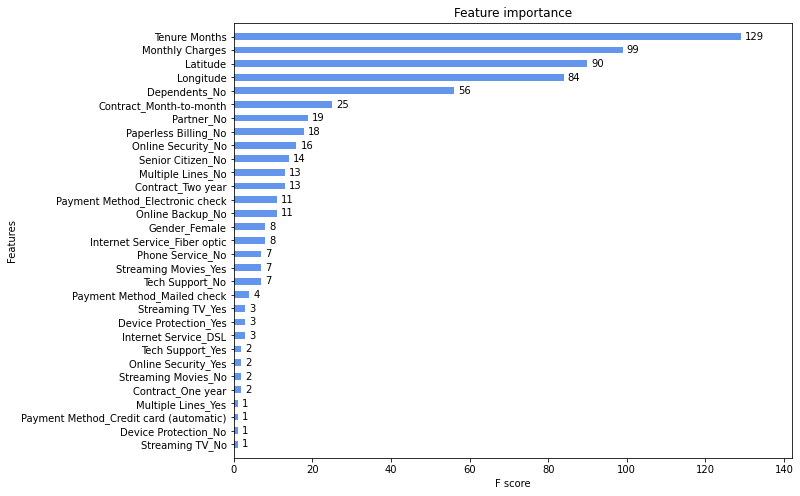

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(xgb_clf, ax=ax, height=0.5, color='cornflowerblue')
plt.grid(False)
plt.show()

## Modelo 3: Regeresión Logística default + dataset optimizado

test/train F1= 1.0
recall = 0.58
precision = 0.67


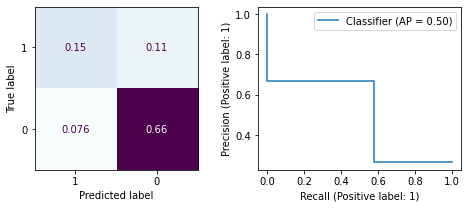

In [ ]:
#Para monitorear el tiempo de ejecución definimos tiempo de comienzo
start = time.time()

#Instanciamos clasificador, lo entrenamos y calculamos predicciones sobre el set de entrenamiento y prueba (usamos 1000 iteraciones porque sino no converge)
logreg_clf = LogisticRegression(max_iter=1000)
logreg_clf.fit(X_train, y_train)
y_pred_test = logreg_clf.predict(X_test)
y_pred_train = logreg_clf.predict(X_train)

#Calculamos tiempo de ejecución
end = time.time()
elapsed_logreg = end - start

#Calculamos y mostramos las métricas relevantes con nuestra función personalizada
_, _, f1_logreg = met_gra(y_test, y_pred_test, y_train, y_pred_train)

## Modelo 4: XGBoost classifier hyperparameter tuning + dataset optimizado 

Evaluation: aucpr  - Scoring metric: balanced_accuracy
{'subsample': 0.8, 'scale_pos_weight': 3, 'max_depth': 3, 'eval_metric': 'aucpr', 'eta': 0.03}
test/train F1= 0.95
recall = 0.82
precision = 0.53


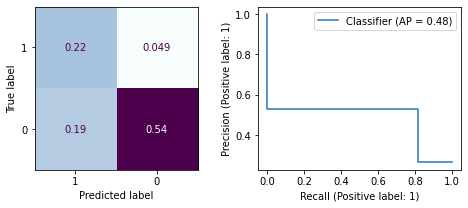



Evaluation: aucpr  - Scoring metric: precision
{'subsample': 1, 'scale_pos_weight': 1, 'max_depth': 2, 'eval_metric': 'aucpr', 'eta': 0.1}
test/train F1= 0.99
recall = 0.58
precision = 0.68


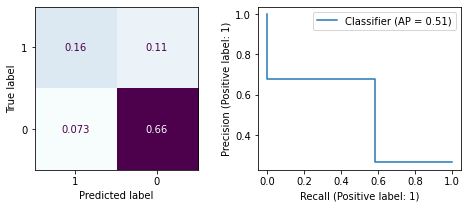



Evaluation: aucpr  - Scoring metric: recall
{'subsample': 0.8, 'scale_pos_weight': 3, 'max_depth': 2, 'eval_metric': 'aucpr', 'eta': 0.03}
test/train F1= 0.98
recall = 0.83
precision = 0.52


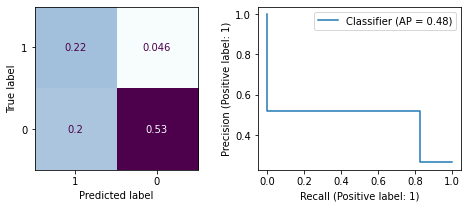



Evaluation: aucpr  - Scoring metric: f1
{'subsample': 0.8, 'scale_pos_weight': 3, 'max_depth': 3, 'eval_metric': 'aucpr', 'eta': 0.03}
test/train F1= 0.95
recall = 0.82
precision = 0.53


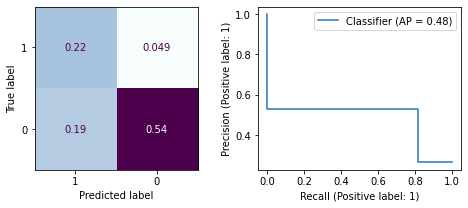



Evaluation: aucpr  - Scoring metric: average_precision
{'subsample': 0.8, 'scale_pos_weight': 1, 'max_depth': 2, 'eval_metric': 'aucpr', 'eta': 0.03}
test/train F1= 0.99
recall = 0.59
precision = 0.68


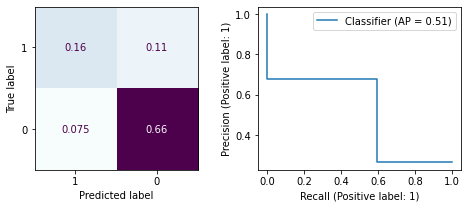



Elapsed: 6 minutes



In [ ]:
#Definimos métricas que vamos a testear en el RSCV
metrics = ['balanced_accuracy', 'precision', 'recall', 'f1', 'average_precision']

#Definimos métricas de evaluación interna de XGB (Habíamos incluído 'auc' y 'logloss' también pero terminaban convergiendo a valores similares de precision y recall)
eval_metrics = ['aucpr']

#Definimos hyperparámetros para testear
eta = [0.03, 0.1, 0.3]
max_depth = [2, 3, 6, 10]
subsample = [0.5, 0.8, 1]
spw = [1, 3]

#Definimos porcentaje de pruebas en relación a las combinaciones posibles
random_ratio = 0.2

#Definimos cantidad de iteraciones del RSCV
n_iter = len(eta) * len(max_depth) * len(subsample) * len(spw) * random_ratio 

#Creamos y preparamos dataframe para guardar y comparar métricas de cada modelo testeado
models = pd.DataFrame()
models['metrics'] = []
models['recall'] = []
models['precision'] = []
models['bestimator'] = []
models['test_predictions'] = []

#Para monitorear el tiempo de ejecución definimos tiempo de comienzo
start = time.time()

#Iteramos a través de las métricas de evalución del modelo (estamos usando una sola en este momento: 'aucpr') y de las de scoring del Random Search
for em in eval_metrics:
  for m in metrics:
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic', seed=seed)
    param_distributions = {'eta': eta,  
                           'max_depth': max_depth,                              
                           'subsample': subsample,
                           'scale_pos_weight': spw,                        
                           'eval_metric': [em]}
    
    #Instanciamos un Random Search CV con nuestro estimador, el diccionario de parámetros y la métrica de scoring corriente
    xgb_rscv = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_distributions, scoring=m, cv=5, n_jobs=-1, random_state=seed, n_iter=n_iter)
    
    #Entrenamos el modelo
    xgb_rscv.fit(X_train, y_train)
    
    #Obtenemos las mejores predicciones sobre el set de prueba y testeo
    y_pred_test = xgb_rscv.best_estimator_.predict(X_test)
    y_pred_train = xgb_rscv.best_estimator_.predict(X_train)
    
    #Mostramos los datos relevantes del mejor modelo para cada métrica de scoring
    print('Evaluation:', em, ' - Scoring metric:', m)
    print(xgb_rscv.best_params_)
    rs, ps, _= met_gra(y_test, y_pred_test, y_train, y_pred_train)
    
    #Guardamos los datos de cada iteración en un mismo dataframe
    models = models.append({'metrics': em+'-'+m, 'recall': rs, 'precision': ps, 'bestimator': xgb_rscv.best_estimator_, 'test_predictions': y_pred_test}, ignore_index=True)
    print('\n')

    #Guardamos cada modelo en un archivo (para usar en la implementación 1)
    xgb_rscv.best_estimator_.save_model(f'{em}-{m}.txt')  

#Calculamos y mostramos el tiempo de ejecución
end = time.time()
elapsed = end - start
print(f'Elapsed: {round(elapsed/60)} minutes\n')

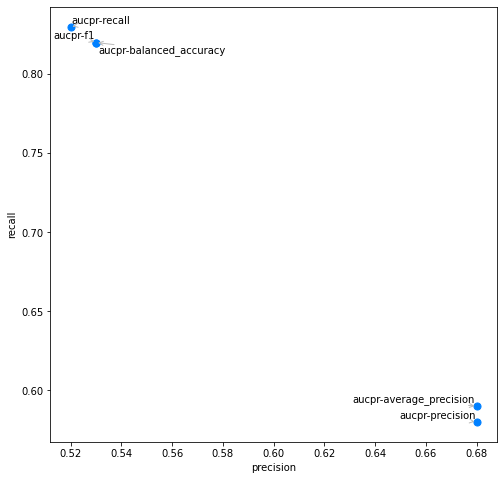

,metrics,recall,precision,bestimator,test_predictions
2,aucpr-recall,0.83,0.52,"XGBClassifier(eta=0.03, eval_metric='aucpr', m...","[0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, ..."
0,aucpr-balanced_accuracy,0.82,0.53,"XGBClassifier(eta=0.03, eval_metric='aucpr', s...","[0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, ..."
3,aucpr-f1,0.82,0.53,"XGBClassifier(eta=0.03, eval_metric='aucpr', s...","[0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, ..."
4,aucpr-average_precision,0.59,0.68,"XGBClassifier(eta=0.03, eval_metric='aucpr', m...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, ..."
1,aucpr-precision,0.58,0.68,"XGBClassifier(eta=0.1, eval_metric='aucpr', ma...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, ..."


In [ ]:
#Mostramos los resultados de precision y recall
models.plot(kind='scatter', x='precision', y='recall', figsize=(8,8), c='#0080ff', s=50)
texts = [plt.text(models['precision'][i], models['recall'][i], models['metrics'][i]) for i in range(models.shape[0])]

#Ajustamos los textos para que no se solapen las etiquetas
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='#bababa'), force_text=(0.3,0.6))
plt.show()

#Mostramos una lista de los modelos ordenados primeros por recall y luego por precision
modelord =  models.sort_values(by=['recall', 'precision'], ascending=False)
display(modelord)

# Conclusiones y observaciones

>Dentro de los modelos optimizados encontramos 2 grupos, uno que maximiza el recall y otro la precision, en función al tipo de acciones que se quieran implementar para mitigar el churn sugerimos usar los modelos de la siguiente manera:<br>
>*  Recomendamos el modelo 'aucpr-recall' si se intenta alcanzar la mayor cantidad de clientes con propensión a la baja con una acción masiva de bajo costo (en el cual alcanzar a un cliente que no tenga intención de baja no tiene un impacto sustancial o negativo). Por ejemplo un boletín con información de los servicios adicionales disponibles de soporte técnico, backup y protección de dispositivos que incluya una bonificación inicial. También el ofrecimiento de estos servicios/promoción en instancias de soporte personalizado. Esto permitirá alcanzar hasta un **<font color='#229c57'>83%</font>** de los clientes con intención de baja al costo de estar brindado la misma a un **<font color='#de7935'>48%</font>** de clientes que de todas maneras permanecerían en la compañia. Dado el churn actual de 27%, para capturar el 83% de las tentativas bajas hay que alcanzar al **<font color='#525252'>43%</font>** de los clientes.
>* En el extremo opuesto, recomendamos el modelo 'aucpr-average_precision' si se intenta alcanzar las potenciales bajas con la mayor eficiencia posible. Apropiado para una acción de mayor costo (en el cual alcanzar a un cliente que no tenga intención de baja tiene un impacto sustancial o negativo), por ejemplo una campaña del call out personalizada o bonificaciones en servicios de alto coste. Esto permitirá tener hasta un **<font color='#336ad6'>68%</font>** de efectividad en el target de clientes con propensión a la baja (es decir que reducimos el desperdicio de **<font color='#de7935'>48%</font>** a **<font color='#de7935'>32%</font>**) a cambio de alcanzar sólo al **<font color='#229c57'>59%</font>** de las potenciales bajas. Para capturar el 59% de las tentativas bajas hay que alcanzar ahora un porción menor que el caso anterior, sólo al **<font color='#525252'>23%</font>** de de los clientes, es decir un 46% relativo al modelo anterior 'aucpr-recall'.

